# INITIALISATION

In [ ]:
from time import time
import os
import shutil
import random
from copy import deepcopy
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image, resize, to_tensor

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
DEFAULTS = { 
            "w": 1,   # float >= 0, harmonisation parameter
            "lr_gen": 0.02,     # float > 0, learning rate of global model
            "lr_node": 0.02,    # float > 0, learning rate of local models
            "NN" : "linear",     # "base" or "conv", neural network architecture
            "opt": optim.Adam,    # any torch optimizer
            "pow_gen": (2, 1),  # generalisation norm  
            }


METRICS = ({"lab":"fit", "ord": "Training Loss", "f_name": "loss"}, 
           {"lab":"gen", "ord": "Training Loss", "f_name": "loss"}, 
           {"lab":"acc_big", "ord": "Accuracy", "f_name": "acc"},
           {"lab":"acc_small", "ord": "Accuracy", "f_name": "acc"}, 
           {"lab":"l2_dist", "ord": "l2 norm", "f_name": "l2dist"}, 
           {"lab":"l2_norm", "ord": "l2 norm", "f_name": "l2dist"}, 
           {"lab":"grad_sp", "ord": "Scalar Product", "f_name": "grad"}, 
           {"lab":"grad_norm", "ord": "Scalar Product", "f_name": "grad"},
           {"lab":"acc_glob", "ord": "Accuracy", "f_name": "acc"},
           )


In [ ]:
os.chdir("/content")
os.makedirs("distribution", exist_ok=True)
os.chdir("/content/distribution")

# DATA

In [ ]:
# data hyperparameters
DATASET = datasets.FashionMNIST
IMG_SIZE = 28
NOISE = 0.6

## functions

In [ ]:
# data import and management

def load_mnist(img_size=IMG_SIZE, noise=NOISE):
    """ return data and labels for train and test mnist dataset """
    #---------------- train data -------------------
    mnist_train = DATASET('data', train=True, download=True)
    data_train = mnist_train.data
    labels_train = [mnist_train[i][1] for i in range(len(data_train))]

    pics = []
    for pic in data_train:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size) # Resize image if needed
        pic = to_tensor(pic)            # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_train = torch.stack(pics)

    #------------------  test data -----------------------
    mnist_test = DATASET('data', train=False, download=True)
    data_test = mnist_test.data
    labels_test = [mnist_test[i][1] for i in range(len(data_test))]

    pics = []
    for pic in data_test:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size)   # Resize image if needed
        pic = to_tensor(pic)             # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_test = torch.stack(pics)

    nb_rd = int(len(labels_train) * noise)  # number of random labels
    for i in range(nb_rd):
        labels_train[i] = random.randint(0, 9)
    return (data_train, labels_train), (data_test,labels_test)

def query(datafull, nb, bias=0, fav=0):
    """ return -nb random samples of -datafull """
    data, labels = datafull
    idxs = list(range(len(data)))
    l = []
    h, w = data[0][0].shape
    d = torch.empty(nb, 1, h, w)
    if bias == 0:
        indexes = random.sample(idxs, nb) # drawing nb random indexes
    else :
        indexes = []
        for i in range(nb):
            idx = one_query(labels, idxs, bias, fav)
            indexes.append(idx)
            idxs.remove(idx) # to draw only once each index max
    for k, i in enumerate(indexes): # filling our query
        d[k] = data[i]
        l.append(labels[i])
    return d, l

def one_query(labels, idxs, redraws, fav):
    """ labels : list of labels
        idxs : list of available indexes
        draws an index with a favorite label choice 
        fav : favorite label
        redraws : max nb of random redraws while fav not found
    """
    lab = -1 
    while lab != fav and redraws >= 0:
        idx = idxs[random.randint(0, len(idxs)-1)]
        lab = labels[idx]
        redraws -= 1
    return idx

def list_to_longtens(l):
    """ change a list into the appropriate ground truths type """
    probas_gt = not (type(l[0]) is int or l[0].shape == 0)
    if probas_gt:
        tens = torch.empty((len(l), 10))
    else:
        tens = torch.empty(len(l), dtype=torch.long)
    for i, lab in enumerate(l): 
        tens[i] = lab
    return tens

def swap(l, n, m):
    """ swap n and m values in l list """
    return [m if (v==n) else n if (v==m) else v for v in l]


def distribute_data_rd(datafull, distrib, fav_lab=(0,0), 
                       dish=False, dish_lab=0, gpu=True): 
    """draw random data on N nodes following distrib
        data, labels : raw data and labels
        distrib : int list, list of nb of data points for each node
        pref_lab : (prefered label, strength of preference (int))
        dish : boolean, if nodes are dishonest 
        dish_lab : 0 to 4, labelisation method

        returns : (list of batches of images, list of batches of labels)
    """
    data, labels = datafull
    N = len(distrib)
    data_dist = []      # list of len N
    labels_dist = []    # list of len N
    fav, strength = fav_lab

    for n, number in enumerate(distrib): #for each node
        d, l = query(datafull, number, strength, fav)
        if gpu:
            data_dist.append(torch.FloatTensor(d).cuda())
        else:
            data_dist.append(torch.FloatTensor(d))
        if dish:                # if dishonest node

            # labels modification
            if dish_lab == 0: # random
                tens = torch.randint(10, (number,), dtype=torch.long)
            elif dish_lab == 1: # zeros
                tens = torch.zeros(number, dtype=torch.long)
            elif dish_lab == 2: # swap 1-7, "strats"
                l = swap(l, 1, 7)
                tens = list_to_longtens(l)
            elif dish_lab == 3: # swap 2 random    
                n, m = random.randint(0,9), random.randint(0,9)
                l = swap(l, n, m)
                tens = list_to_longtens(l)
            elif dish_lab == 4: # label +1, "jokers"
                tens = (list_to_longtens(l) + 1) % 10

        else:           # if honest node 
            tens = list_to_longtens(l) # needed for CrossEntropy later
        if gpu:
            tens = tens.cuda()

        labels_dist.append(tens)

    return data_dist, labels_dist

## get data

In [ ]:
# downloading data
if 'train' not in globals(): # to avoid loading data every time
    train, test = load_mnist()
    if torch.cuda.is_available():
        test_gpu = torch.tensor(test[0]).cuda(), torch.tensor(test[1]).cuda()

# MODELS

In [ ]:
# model architecture (2 options)

def get_base_classifier(gpu=True):
    """ returns linear baseline classifier """
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(IMG_SIZE**2, 10),
        )
    if gpu:
        return model.cuda()
    return model

def get_2l_classifier(gpu=True):
    """ returns linear baseline classifier """
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(IMG_SIZE**2, IMG_SIZE**2),
        torch.nn.ReLU(),
        nn.Linear(IMG_SIZE**2, 10),
        )
    if gpu:
        return model.cuda()
    return model

MODELS = {"linear": get_base_classifier, '2layers': get_2l_classifier}

# TRAINING STRUCTURE

## Losses

In [ ]:
# loss and scoring functions 

def local_loss(model_loc, x, y, reduction='sum'):  
    """ classification loss """
    loss = nn.CrossEntropyLoss(reduction=reduction)
    predicted = model_loc(x)
    local = loss(predicted, y)
    return local

def models_dist(model_loc, model_glob, pow=(1, 1)):  
    """ l1 distance between global and local parameter
        will be mutliplied by w_n 
        pow : (internal power, external power)
    """
    q, p = pow
    dist = sum(((theta - rho)**q).abs().sum() for theta, rho in 
                  zip(model_loc.parameters(), model_glob.parameters()))**p
    return dist

def model_norm(model_glob, pow=(2,1)): 
    """ l2 squared regularisation of global parameter
     will be multiplied by w_0 
     pow : (internal power, external power)
     """
    q, p = pow
    norm = sum((param**q).abs().sum() for param in model_glob.parameters())**p
    return norm

def round_loss(tens, dec=0): 
    """from an input scalar tensor returns rounded integer"""
    if type(tens)==int or type(tens)==float:
        return round(tens, dec)
    else:
        return round(tens.item(), dec)

def tens_count(tens, val):
    """ counts nb of -val in tensor -tens """
    return len(tens) - round_loss(torch.count_nonzero(tens-val))

def score(model, datafull):
    """ returns accuracy provided models, images and GTs """
    with torch.no_grad():
        out = model(datafull[0])
        predictions = torch.max(out, 1)[1]
        c=0
        for a, b in zip(predictions, datafull[1]):
            c += int(a==b)
        return c/len(datafull[0])


## Flower

### flower class

In [ ]:
# nodes repartition

class Flower():
    """ Training structure including local models and general one 
        Allowing to add and remove nodes at will
        .pop
        .add_nodes
        .rem_nodes
        .train
        .display
        .check
    """

    def __init__(self, test, gpu=True, **kwargs):
        """ opt : optimizer
            test : test data couple (imgs,labels)
        """
        self.d_test = test
        self.gpu = gpu

        self.opt = kwargs["opt"]
        self.lr_node = kwargs["lr_node"]
        self.lr_gen = kwargs["lr_gen"]

        self.get_classifier = MODELS[kwargs["NN"]]
        self.general_model = self.get_classifier(gpu)
        self.init_model = deepcopy(self.general_model)
        self.last_grad = None
        self.opt_gen = self.opt(self.general_model.parameters(), lr=self.lr_gen)
        self.pow_gen = kwargs["pow_gen"]  # choice of norms for Licchavi loss
        self.data = []
        self.labels = [] 
        self.typ = []
        self.models = []
        self.weights = []
        self.age = []
        self.opt_nodes = []
        self.nb_nodes = 0
        self.dic = {"honest" : -1, "trolls" : 0, "zeros" : 1, 
                    "one_evil" : 2, "strats" : 3, "jokers" : 4, "byzantine" : -1,
                    'freezed' : -1}
        self.history = ([], [], [], [], [], [], [], [], []) 
        # ("fit", "gen", "acc_big", "acc_small", "l2_dist", "l2_norm", "grad_sp", "grad_norm", "acc_glob")

    # ------------ population methods --------------------

    def add_nodes(self, datafull, pop, typ, fav_lab=(0,0), verb=1, **kwargs):
        """ add nodes to the Flower 
            datafull : data to put on node (sampled from it)
            pop : (nb of nodes, size of nodes)
            typ : type of nodes (str keywords)
            fav_lab : (favorite label, strength)
            w : int, weight of new nodes
        """
        w = kwargs["w"] # taking global variable if -w not provided
        nb, size = pop
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size] * nb, fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        self.data += dt
        self.labels += lb
        self.typ += [typ] * nb

        self.models += [self.get_classifier(self.gpu) for i in range(nb)]
        self.weights += [w] * nb
        self.age += [0] * nb
        self.nb_nodes += nb
        self.opt_nodes += [self.opt(self.models[n].parameters(), lr=self.lr_node) 
            for n in range(self.nb_nodes - nb, self.nb_nodes) 
            ]
        if verb:
            print("Added {} {} nodes of {} data points".format(nb, typ, size))
            print("Total number of nodes : {}".format(self.nb_nodes))

    def rem_nodes(self, first, last, verb=1):
        """ remove nodes of indexes -first (included) to -last (excluded) """
        nb = last - first
        if last > self.nb_nodes:
            print("-last is out of range, remove canceled")
        else:
            del self.data[first : last]
            del self.labels[first : last] 
            del self.typ[first : last]
            del self.models[first : last]
            del self.weights[first : last]
            del self.age[first : last]
            del self.opt_nodes[first : last]
            self.nb_nodes -= nb
            if verb: print("Removed {} nodes".format(nb))
        
    def hm(self, ty):
        """ count nb of nodes of this type """
        return self.typ.count(ty)
    
    def pop(self):
        """ return dictionnary of population """
        c = {}
        for ty in self.dic.keys():
            c[ty] = self.hm(ty)
        return c

    # ------------- scoring methods -----------
    def score_glob(self, datafull): 
        """ return accuracy provided images and GTs """
        return score(self.general_model, datafull)
    
    def score_loc(self, node):
        """ score of node on global test data """
        return score(self.models[node], self.d_test)

    def score_nodes(self, l_nodes):
        """ mean local test scores of nodes """
        score_tot = 0
        for node in l_nodes:
            score_tot += score(self.models[node], self.d_test)
        return score_tot / len(l_nodes)

    def test_train(self, node):
        """ score of node on its train data """
        return score(self.models[node], (self.data[node], self.labels[node]))

    def display(self, node):
        """ display accuracy for selected node
            node = -1 for global model
        """
        if node == -1: # global model
            print("global model")
            print("accuracy on test data :", 
                  self.score_glob(self.d_test))
        else: # we asked for a node
            loc_train = self.test_train(node)
            full_test = self.score_loc(node)
            print("node number :", node, ", dataset size :",
                len(self.labels[node]), ", type :", self.typ[node], 
                ", age :", self.age[node])
            print("accuracy on local train data :", loc_train)
            print("accuracy on global test data :", full_test)
            repart = {str(k) : tens_count(self.labels[node], k) 
                for k in range(10)}
            print("labels repartition :", repart)
    
    # ---------- methods for training ------------
    def _lr_schedule(self, schedule):
        """ changes learning rates during trainning """
        decay, lr_min = schedule
        if self.lr_node >= lr_min / decay:
            self.lr_node *= decay
            self.lr_gen *= decay

    def _set_lr(self, reduction):
        """set learning rates of optimizers according to Flower setting"""
        for n in range(self.nb_nodes):
            self.opt_nodes[n].param_groups[0]['lr'] = self.lr_node
        self.opt_gen.param_groups[0]['lr'] = self.lr_gen

    def _zero_opt(self):
        """reset gradients of all models"""
        for n in range(self.nb_nodes):
            self.opt_nodes[n].zero_grad()      
        self.opt_gen.zero_grad()

    def _update_hist(self, epoch, test_freq, fit, gen, verb=1):
        """ update history """
        acc_small = self.score_loc(0)
        acc_big = self.score_loc(self.nb_nodes - 1)
        acc_glob = self.score_glob(self.d_test)
        self.history[2].append(acc_big) 
        self.history[3].append(acc_small) 
        self.history[8].append(acc_glob) 
        self.history[0].append(round_loss(fit))
        self.history[1].append(round_loss(gen))

        dist = models_dist(self.init_model, self.general_model, pow=(2,0.5)) 
        norm = model_norm(self.general_model, pow=(2,0.5))
        self.history[4].append(round_loss(dist, 1))
        self.history[5].append(round_loss(norm, 1))
        grad_gen = extract_grad(self.general_model)
        if epoch > 1: # no last model for first epoch
            scal_grad = sp(self.last_grad, grad_gen)
            self.history[6].append(scal_grad)
        else:
            self.history[6].append(0) # default value for first epoch
        self.last_grad = deepcopy(extract_grad(self.general_model)) 
        grad_norm = math.sqrt(sp(grad_gen, grad_gen))
        self.history[7].append(grad_norm)

    def _old(self, years):
        """ increment age (after training) """
        for i in range(self.nb_nodes):
            self.age[i] += years
    
    def _do_all_step(self):
        for n in range(self.nb_nodes): 
            self.opt_nodes[n].step()
        self.opt_gen.step() 

    def _print_losses(self, tot, fit, gen):
        """print losses"""
        print("total loss : ", tot) 
        print("fitting : ", round_loss(fit),
                ', generalisation : ', round_loss(gen))
    # ====================  TRAINING ================== 

    def train(
            self, nb_epochs=None, test_freq=1, verb=1, 
            reduction='sum', schedule=(1, 0)):   
        """training loop"""
        # nb_epochs = EPOCHS if nb_epochs is None else nb_epochs
        time_train = time()

        # initialisation to avoid undefined variables at epoch 1
        loss, fit_loss, gen_loss = 0, 0, 0
        c_fit, c_gen = 0, 0

        # training loop 
        for epoch in range(1, nb_epochs + 1):
            if verb: print("\nepoch {}/{}".format(epoch, nb_epochs))
            time_ep = time()
            self._zero_opt() # resetting gradients

            self._lr_schedule(schedule)
            self._set_lr(reduction)
            
            # ------- loss computation --------------------------
            fit_loss, gen_loss = 0, 0
            
            for n in range(self.nb_nodes):   # for each node
                fit_loss += local_loss(
                    self.models[n], self.data[n], self.labels[n], reduction
                )

                gen = models_dist(
                    self.models[n], self.general_model, self.pow_gen
                )

                gen_loss += self.weights[n] * gen  # generalisation term
            if reduction == 'sum':  # harmonisation to better compare
                fit_loss /= (sum(len(data) for data in self.data) / self.nb_nodes) # mean of data points per node
            loss = fit_loss + gen_loss

            # -----------------------------------------------
            total_out = round_loss(fit_loss + gen_loss)
            if verb >= 2:
                self._print_losses(total_out, fit_loss, gen_loss)
            # Gradient descent 
            loss.backward()
            self._do_all_step()
 
            if verb: 
                print("epoch time :", round(time() - time_ep, 2)) 
            self._update_hist(epoch, test_freq, fit_loss, gen_loss, verb)
            self._old(1)  # aging all nodes
             
        # ----------------- end of training -------------------------------  
        for i in range(nb_epochs % test_freq): # to maintain same history length
            self.history[3].append(acc)
        print("training time :", round(time() - time_train, 2)) 
        return self.history

    # ------------ to check for problems --------------------------
    def check(self):
        """ perform some tests on internal parameters adequation """
        # population check
        b1 =  (self.nb_nodes == len(self.data) == len(self.labels) 
            == len(self.typ) == len(self.models) == len(self.opt_nodes) 
            == len(self.weights) == len(self.age))
        # history check
        b2 = True
        for l in self.history:
            b2 = b2 and (len(l) == len(self.history[0]) >= max(self.age))
        if (b1 and b2):
            print("No Problem")
        else:
            print("Coherency problem in Flower object")


### flower utility

In [ ]:
def get_flower(gpu=True, **kwargs):
    """get a Flower using the appropriate test data (gpu or not)"""
    if gpu:
        return Flower(test_gpu, gpu=gpu, **kwargs)
    return Flower(test, gpu=gpu, **kwargs)

def extract_grad(model):
    """return list of gradients of a model"""
    l_grad =  [p.grad for p in model.parameters()]
    return l_grad

def sp(l_grad1, l_grad2):
    """scalar product of 2 lists of gradients"""
    s = 0
    for g1, g2 in zip(l_grad1, l_grad2):
        s += (g1 * g2).sum()
    return round_loss(s, 4)


# PLOTTING FUNCTIONS

## Plotting utilities

In [ ]:
INTENS = 0.4  # intensity of sublines

def seedall(s):
    """seed all sources of randomness"""
    reproducible = (s >= 0)
    torch.manual_seed(s)
    random.seed(s)
    np.random.seed(s)
    torch.backends.cudnn.deterministic = reproducible
    torch.backends.cudnn.benchmark     = not reproducible
    print("\nSeeded all to", s)

def replace_dir(path):
    """ create or replace directory """
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

def get_style():
    """give different line styles for plots"""
    l = ["-","-.",":","--"]
    for i in range(10000):
        yield l[i % 4]

def get_color():
    """give different line styles for plots"""
    l = ["red","green","blue","grey"]
    for i in range(10000):
        yield l[i % 4]

def set_styles():
    """ sets the global generators variables """
    global STYLES
    global COLORS
    STYLES = get_style() 
    COLORS = get_color()

def title_save(title=None, path=None, suff=".pdf"):
    """ add title and save plot """
    if title is not None:   
        plt.title(title)
    if path is not None:
        plt.savefig(path + suff, bbox_inches='tight')

def legendize(y):
    """ label axis of plt plot """
    plt.xlabel("Epochs")
    plt.ylabel(y)
    plt.legend()


## Plotting from history

In [ ]:
# functions to display training history 

def means_bounds(arr):
    """ from array return 1 array of means, 
        1 of (mean - var), 1 of (mean + var)
    """
    means = np.mean(arr, axis=0)
    var = np.var(arr, axis = 0) 
    low, up = means - var, means + var
    return means, low, up

# ----------- to display multiple accuracy curves on same plot -----------
def add_acc_var(arr, label):
    """ from array add curve of accuracy """
    acc = arr[:,3,:]
    means, low, up = means_bounds(acc)
    epochs = range(1, len(means) + 1)
    plt.plot(epochs, means, label=label, linestyle=next(STYLES))
    plt.fill_between(epochs, up, low, alpha=0.4)

# ------------- utility for what follows -------------------------
def plot_var(l_hist, l_idx):
    """ add curve of asked indexes of history to the plot """
    arr_hist = np.asarray(l_hist)
    epochs = range(1, arr_hist.shape[2] + 1)
    for idx in l_idx:
        vals = arr_hist[:,idx,:]
        vals_m, vals_l, vals_u = means_bounds(vals)
        style, color = next(STYLES), next(COLORS)
        plt.plot(epochs, vals_m, label=METRICS[idx]["lab"], linestyle=style, color=color)
        plt.fill_between(epochs, vals_u, vals_l, alpha=INTENS, color=color)

def plotfull_var(l_hist, l_idx, title=None, path=None, show=True):
    """ plot metrics asked in -l_idx and save if -path provided """
    plot_var(l_hist, l_idx)
    idx = l_idx[0]
    legendize(METRICS[idx]["ord"])
    title_save(title, path, suff="{}.pdf".format(METRICS[idx]["f_name"]))
    if show: 
        plt.show()

# ------- groups of metrics on a same plot -----------
def loss_var(l_hist, title=None, path=None):
    """ plot losses with variance from a list of historys """
    plotfull_var(l_hist, [0,1], title, path)

def acc_var(l_hist, title=None, path=None):
    """ plot accuracy with variance from a list of historys """
    plt.ylim([0,1])
    plt.grid(True, which='major', linewidth=1, axis='y', alpha=1)
    plt.minorticks_on()
    plt.grid(True, which='minor', linewidth=0.8, axis='y', alpha=0.8)
    plotfull_var(l_hist, [2, 3, 8], title, path)

def l2_var(l_hist, title=None, path=None):
    """plot l2 norm of gen model from a list of historys"""
    plotfull_var(l_hist, [4,5], title, path)

def gradsp_var(l_hist, title=None, path=None):
    """ plot scalar product of gradients between 2 consecutive epochs
        from a list of historys
    """
    plotfull_var(l_hist, [6,7], title, path)

# plotting all we have
def plot_metrics(l_hist, title=None, path=None):
    """plot and save the different metrics from list of historys"""
    set_styles()
    acc_var(l_hist, title, path)  
    # loss_var(l_hist, title, path)
    # l2_var(l_hist, title, path)
    # gradsp_var(l_hist, title, path)

# TRAININGS

In [ ]:
def replace_models(flow, l_nodes, model):
    """ replaces models of nodes of l_nodes by model in flow """
    with torch.no_grad():
        for node in l_nodes:
            for par1, par2 in zip(flow.models[node].parameters(), model.parameters()):
                for i, par in enumerate(par2):
                    par1[i] = par  # deepcopy ?

In [ ]:
# choosing parameters

NB_SMALL = 10  # number of "idle" users
SMALL_SIZE = 10  # number of data points per idle user
NB_BIG = 1  # number of "active" users
BIG_SIZE = 60_000  # number of data points per active user
W = 100  # the "lambda" parameter

NB_EPS = 200  # number of training epochs
LR = 0.04  # learning rate
SCHEDULE = (0.99, 0.02)  # (lr decay, min learning rate)
OPT = optim.Adam  # optimizer

MODEL = '2layers'  # model used ("linear" or "2layers")

# setting configuration
config = deepcopy(DEFAULTS)
config['opt'] = OPT
config['pow_gen'] = (2, 1)  # regularisation norm 
config['w'] = W

config['NN'] = MODEL
config['lr_gen'] = LR
config['lr_node'] = LR

In [ ]:
# AVERAGE

seedall(999)
flow_average = get_flower(**config)
flow_average.add_nodes(train, pop=(NB_SMALL, SMALL_SIZE), typ='honest', **config)
flow_average.add_nodes(train, pop=(NB_BIG, BIG_SIZE), typ='honest', **config)

hist_average = flow_average.train(NB_EPS, verb=0, reduction='mean', schedule=SCHEDULE)
flow_average.check()


Seeded all to 999
Added 10 honest nodes of 10 data points
Total number of nodes : 10
Added 1 honest nodes of 60000 data points
Total number of nodes : 11
training time : 150.11
No Problem


In [ ]:
# SUM

seedall(999)
flow_sum = get_flower(**config)
flow_sum.add_nodes(train, pop=(NB_SMALL, SMALL_SIZE), typ='honest', **config)
flow_sum.add_nodes(train, pop=(NB_BIG, BIG_SIZE), typ='honest', **config)

hist_sum = flow_sum.train(NB_EPS, verb=0, reduction='sum', schedule=SCHEDULE)
flow_sum.check()


Seeded all to 999
Added 10 honest nodes of 10 data points
Total number of nodes : 10
Added 1 honest nodes of 60000 data points
Total number of nodes : 11
training time : 150.02
No Problem


# RESULTS

In [ ]:
# accuracy of global models
print('AVERAGE')
flow_average.display(-1)
print('SUM')
flow_sum.display(-1)

# mean local accuracy of honest nodes
average_small, average_big, sum_small, sum_big = 0, 0, 0, 0

print('\nLocal accuracys')
print('AVERAGE', 'SUM')
print('small nodes')
for node in range(NB_SMALL):
    average_s, sum_s = flow_average.score_nodes([node]), flow_sum.score_nodes([node])
    print(average_s, sum_s)
    average_small += average_s
    sum_small += sum_s

print('big node')
for node in range(NB_SMALL, NB_SMALL + NB_BIG):
    average_b, sum_b = flow_average.score_nodes([node]), flow_sum.score_nodes([node])
    print(average_b, sum_b)
    average_big += average_b
    sum_big += sum_b

print('\nAverage accuracys')
print(f'average small : {average_small / NB_SMALL}', f'sum small : {sum_small / NB_SMALL}')
print(f'average big : {average_big / NB_BIG}', f'sum big : {sum_big / NB_BIG}')

AVERAGE
global model
accuracy on test data : 0.2629
SUM
global model
accuracy on test data : 0.5811

Local accuracys
AVERAGE SUM
small nodes
0.2631 0.5805
0.2573 0.5806
0.2677 0.5807
0.2625 0.5806
0.2622 0.5807
0.2582 0.5807
0.2639 0.5806
0.2625 0.5806
0.2681 0.5807
0.2681 0.5805
big node
0.2642 0.5876

Average accuracys
average small : 0.26336 sum small : 0.5806200000000001
average big : 0.2642 sum big : 0.5876


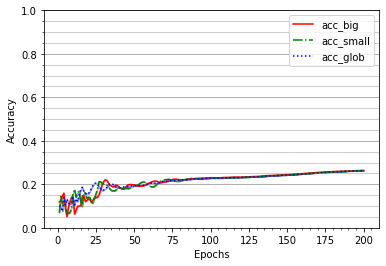

In [ ]:
plot_metrics([hist_average], title='', path= str(W).replace('.', '') + 'average_')  # FIXME add title

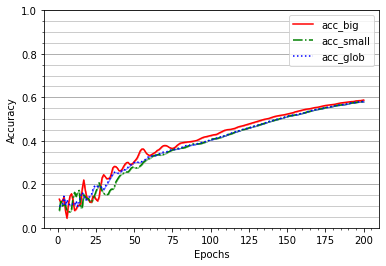

In [ ]:
plot_metrics([hist_sum], title='', path= str(W).replace('.', '') + 'sum_') # FIXME add title